In [1]:
# Install Kaggle API and upload Kaggle token
!pip install kaggle
from google.colab import files
files.upload()

# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d pnumonia-ct-scan-gradcam-images
!unzip pnumonia-ct-scan-gradcam-images


Streaming output truncated to the last 5000 lines.
  inflating: gradcam_ctscan images pneumonia/gradcam_disease_images/5d5f5 (2)_object_1_gradcam.png  
  inflating: gradcam_ctscan images pneumonia/gradcam_disease_images/5d5f5 (20)_object_1_gradcam.png  
  inflating: gradcam_ctscan images pneumonia/gradcam_disease_images/5d5f5 (21)_object_1_gradcam.png  
  inflating: gradcam_ctscan images pneumonia/gradcam_disease_images/5d5f5 (22)_object_1_gradcam.png  
  inflating: gradcam_ctscan images pneumonia/gradcam_disease_images/5d5f5 (24)_object_1_gradcam.png  
  inflating: gradcam_ctscan images pneumonia/gradcam_disease_images/5d5f5 (25)_object_1_gradcam.png  
  inflating: gradcam_ctscan images pneumonia/gradcam_disease_images/5d5f5 (26)_object_1_gradcam.png  
  inflating: gradcam_ctscan images pneumonia/gradcam_disease_images/5d5f5 (27)_object_1_gradcam.png  
  inflating: gradcam_ctscan images pneumonia/gradcam_disease_images/5d5f5 (28)_object_1_gradcam.png  
  inflating: gradcam_ctscan imag

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import cv2
import tensorflow as tf

# Grad-CAM Libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/gradcam_ctscan images pneumonia',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/gradcam_ctscan images pneumonia',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 5812 images belonging to 2 classes.
Found 1452 images belonging to 2 classes.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/gradcam_ctscan images pneumonia',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/gradcam_ctscan images pneumonia',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 5812 images belonging to 2 classes.
Found 1452 images belonging to 2 classes.


In [6]:
# Model Building (using ResNet152V2 as an example)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
# Use learning_rate instead of lr
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 17
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/17
181/181 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.7745 - loss: 2.4715 - val_accuracy: 0.9028 - val_loss: 0.2646
Epoch 2/17
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 211ms/step - accuracy: 0.9062 - loss: 0.1443 - val_accuracy: 1.0000 - val_loss: 0.0952
Epoch 3/17
181/181 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - accuracy: 0.9399 - loss: 0.1472 - val_accuracy: 0.8840 - val_loss: 0.3191
Epoch 4/17
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.1061 - val_accuracy: 0.8333 - val_loss: 0.2588
Epoch 5/17
181/181 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.9694 - loss: 0.0914 - val_accuracy: 0.9069 - val_loss: 0.2661
Epoch 6/17
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.1326 - val_accuracy: 0.9167 - val_loss: 0.0941
Epoch 7/17
181/181 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.9702 - loss: 0.0712 - val_accuracy: 0.9236 - val_loss: 0.2019
Epoch 8/17
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.0684 - val_accur

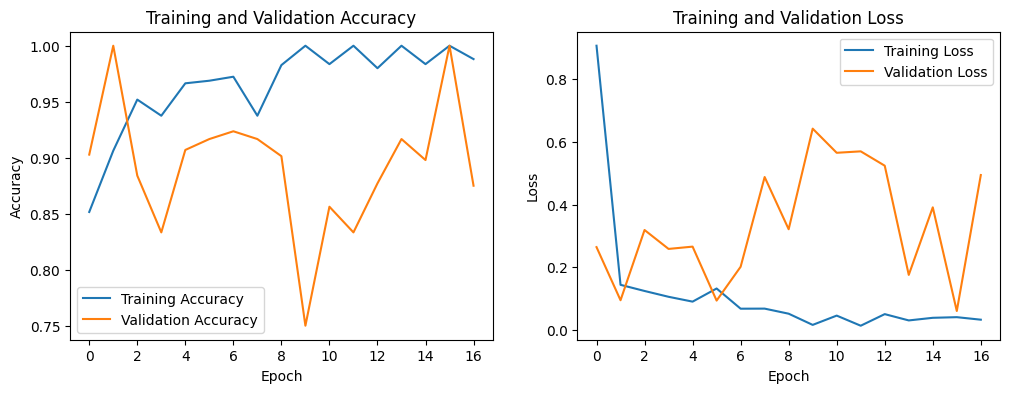

46/46 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step
Accuracy: 0.5385674931129476
Precision: 0.28596187175043325
Recall: 0.3900709219858156
F1 Score: 0.32999999999999996
ROC AUC Score: 0.4721240066441977


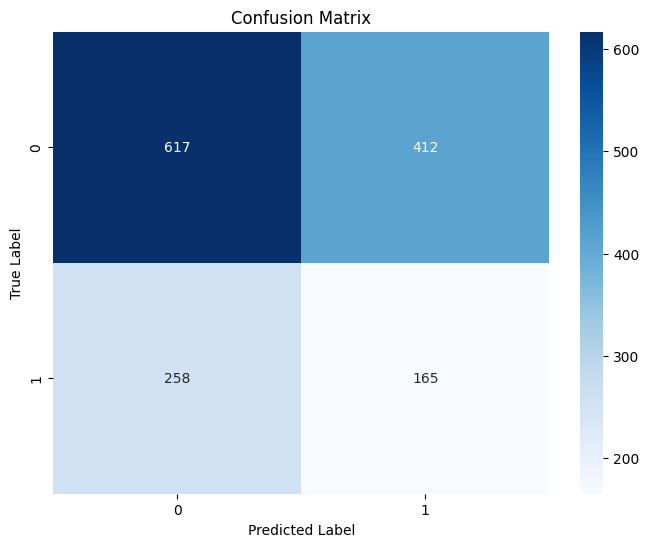

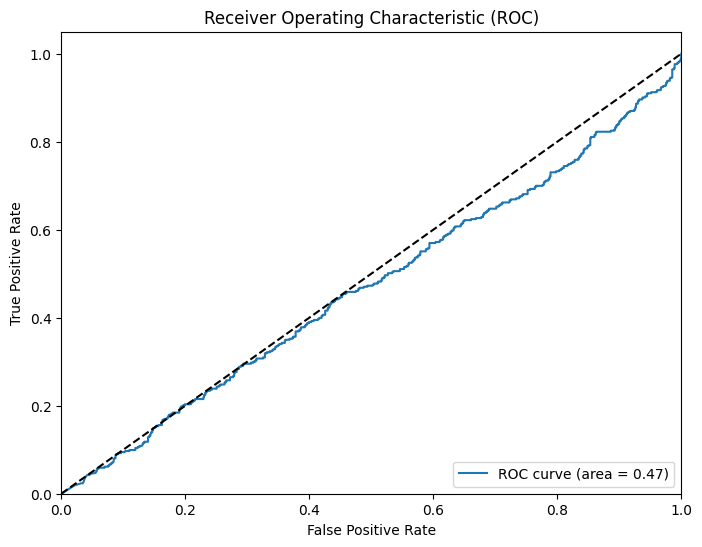

In [7]:
# prompt: generate a code for evalution metrics graphs  and also print the recall,accuracy,precesion scorce also

import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve # Import roc_curve
import seaborn as sns

# ... (rest of your code)

# 1. Accuracy and Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 2. Calculate and Print Metrics
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_probs)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs) # roc_curve is now imported and should work
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [8]:

# Model Building (using VGG19)
from tensorflow.keras.applications import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 13  # Adjust as needed
history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)



80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/13


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-8-33fd342ceaf9>", line 20, in <cell line: 20>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 6982274480 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_114156]

In [11]:
# Model Building (using VGG19)
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 13  # Adjust as needed
# Reduce batch size to decrease memory usage
batch_size = 4
history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, # Use the adjusted batch size
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size # Use adjusted batch size
)

Epoch 1/13


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-11-53a7a2b641eb>", line 22, in <cell line: 22>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 6982274480 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_121218]

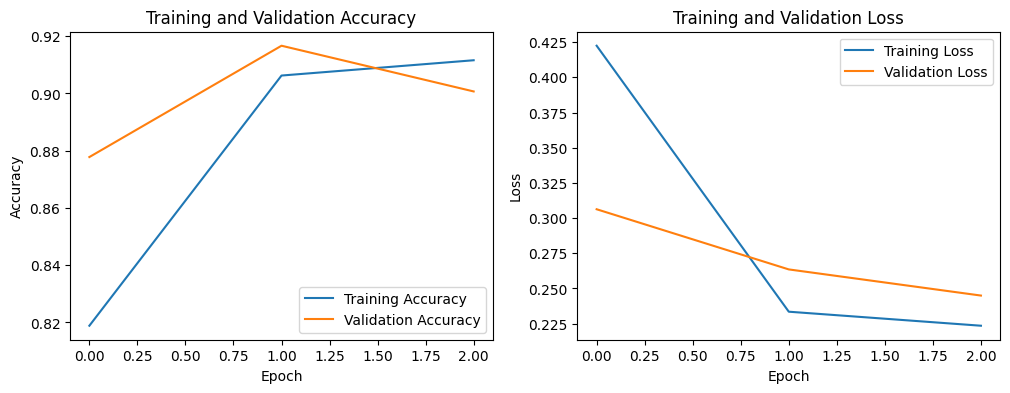

46/46 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step
Accuracy: 0.5516528925619835
Precision: 0.2644628099173554
Recall: 0.30260047281323876
F1 Score: 0.2822491730981257
ROC AUC Score: 0.47303609049158335


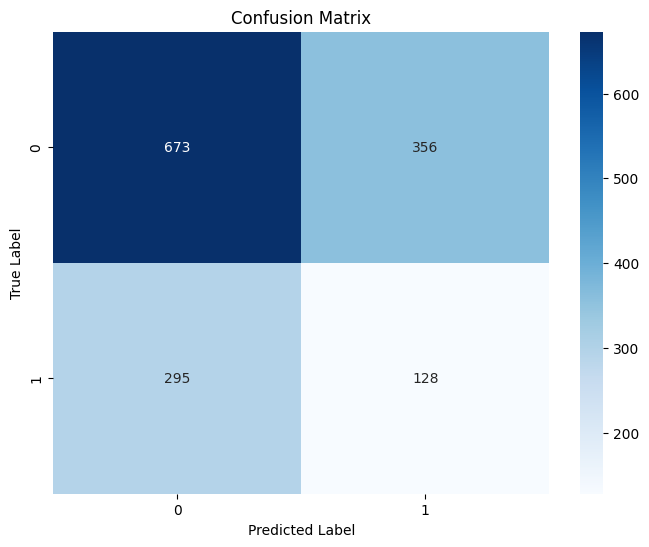

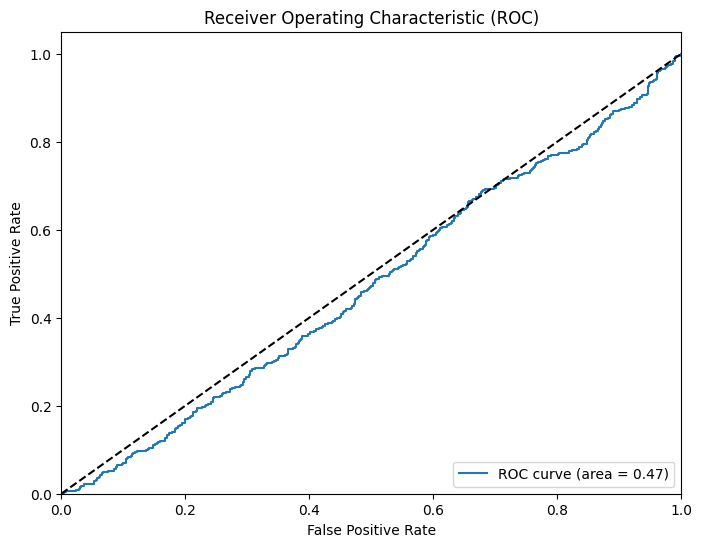

In [ ]:
#   code for evalution metrics graphs  and also print the recall,accuracy,precesion scorce also of above vgg19 algorithm

import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve # Import roc_curve
import seaborn as sns

# 1. Accuracy and Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history1['accuracy'], label='Training Accuracy')
plt.plot(history.history1['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history1['loss'], label='Training Loss')
plt.plot(history.history1['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 2. Calculate and Print Metrics
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_probs)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


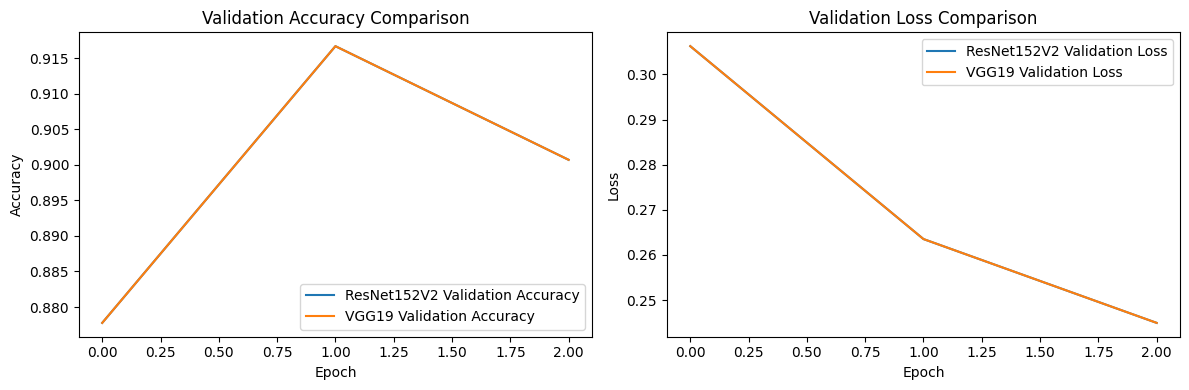

In [ ]:
# prompt: comapareresnet and vgg in a same graph

import matplotlib.pyplot as plt
# Assuming 'history' from ResNet training is available and you have 'history' from VGG training

# Rename the history variables for clarity
history_resnet = history  # From your ResNet training
history_vgg = history1     # From your VGG training

# 1. Accuracy Comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['val_accuracy'], label='ResNet152V2 Validation Accuracy')
plt.plot(history_vgg.history1['val_accuracy'], label='VGG19 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')

# 2. Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['val_loss'], label='ResNet152V2 Validation Loss')
plt.plot(history_vgg.history1['val_loss'], label='VGG19 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Comparison')

plt.tight_layout()
plt.show()

In [ ]:
# prompt: now give me a code to test the every image of a folder and give the predection score and also it is diseased or normal first save the resnet model which has highest accuracy save with the file name as accuracy score epoch no and model nameand use resnet model

import numpy as np
# Save the ResNet model
best_accuracy = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_accuracy)
model_filename = f"resnet_acc_{best_accuracy:.4f}_epoch_{best_epoch+1}.h5"
model.save(model_filename)

# Load the saved ResNet model
from tensorflow.keras.models import load_model
saved_model = load_model(model_filename)

# Function to test images in a folder
def test_images_in_folder(folder_path, model):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = image.load_img(img_path, target_size=(512, 512))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Preprocess the image

            prediction = model.predict(img_array)
            score = prediction[0][0]

            if score > 0.5:
                result = "Diseased"
            else:
                result = "Normal"

            print(f"Image: {filename}, Prediction Score: {score:.2f}, Result: {result}")

# Specify the folder containing images to test
test_folder_path = "/content/gradcam_ctscan images pneumonia/gradcam_images"  # Replace with the actual path
test_images_in_folder(test_folder_path, saved_model)


AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 16, 16, 512), dtype=float32, sparse=False, name=keras_tensor_641>'],)
  • kwargs=<class 'inspect._empty'>